# User engagement analysis
### Phase 1: Data Preparation, Metric aggregation and ranking
1. Clean the Data: Handle missing values, outliers, and ensure consistent formats.
2. Compute Metrics: Calculate session frequency, session duration, and total traffic (upload & download) per user.
### Phase 2: Clustering and Analysis
1. Normalize Metrics: Standardize the engagement metrics for comparability.
2. Initial k-Means Clustering: Run k-means clustering (k=3) to classify customers into three engagement groups.
3. Cluster Analysis: Calculate and analyze the minimum, maximum, average, and total metrics for each cluster. Visualize and interpret the results.

### Phase 3: Application-Level Engagement
1. Per-App Traffic: Aggregate user total traffic per application and identify the top 10 most engaged users per app.
2. Top 3 Applications: Visualize the usage statistics for the top 3 most used applications.

### Phase 4: Clustering Refinement
1. Elbow Method: Use the elbow method to determine the optimal value of k for clustering.
2. Refined Clustering: Re-run k-means clustering using the optimal k and interpret the findings.


### Phase 1: Data preparation

In [2]:
pip install psycopg2-binary sqlalchemy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: psycopg2-binary in c:\users\beab\desktop\kifiya aim\investor-feasibility-analysis\venv\lib\site-packages (2.9.9)




[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [4]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy

In [5]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


c:\Users\Beab\Desktop\Kifiya AIM\Investor-feasibility-analysis\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [6]:
import pandas as pd

# Assuming df is your DataFrame
# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Function to identify and replace outliers using IQR method
def handle_outliers_iqr(df):
    df_cleaned = df.copy()  # Create a copy of the DataFrame for modifications
    outlier_info = {}  # Dictionary to store information about outliers
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        
        # Store the count of outliers
        outlier_info[column] = outliers.shape[0]
        
        # Replace outliers with median of the column
        median_value = df_cleaned[column].median()
        df_cleaned.loc[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound), column] = median_value
    
    return df_cleaned, outlier_info

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())


Number of rows before outlier removal: 150001
Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...

### Data cleaning

Looking for outliers and replacing them using advanced methods like imputation.

In [7]:
import pandas as pd

# Assuming df is your DataFrame
# Display the number of rows before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Function to identify and replace outliers using IQR method
def handle_outliers_iqr(df):
    df_cleaned = df.copy()  # Create a copy of the DataFrame for modifications
    outlier_info = {}  # Dictionary to store information about outliers
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df_cleaned[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)]
        
        # Store the count of outliers
        outlier_info[column] = outliers.shape[0]
        
        # Replace outliers with median of the column
        median_value = df_cleaned[column].median()
        df_cleaned.loc[(df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound), column] = median_value
    
    return df_cleaned, outlier_info

# Apply the function to handle outliers
df_cleaned, outlier_info = handle_outliers_iqr(df)

# Display the number of rows after outlier removal
print(f"Number of rows after outlier removal: {df_cleaned.shape[0]}")

# Display information about outliers
total_outliers_removed = sum(outlier_info.values())
print(f"\nTotal number of outliers removed: {total_outliers_removed}")

# Store the cleaned DataFrame in a new DataFrame
df_outliers_removed = df_cleaned.copy()

# Optionally, display the cleaned DataFrame's first few rows
print("\nFirst few rows of the DataFrame with outliers removed:")
print(df_outliers_removed.head())


Number of rows before outlier removal: 150001
Number of rows after outlier removal: 150001

Total number of outliers removed: 451082

First few rows of the DataFrame with outliers removed:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0    86399.0  2.082014e+14   3.366496e+10  3.552121e+13   
1    86399.0  2.082019e+14   3.368185e+10  3.579401e+13   
2    86399.0  2.082015e+14   3.366371e+10  3.528151e+13   
3    86399.0  2.082014e+14   3.366371e+10  3.535661e+13   
4    86399.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...

Looking for missing values and replacing them using advanced statistics techniques like imputation.

In [8]:
import pandas as pd

# Function to handle missing values using advanced statistical methods
def handle_missing_values(df):
    df_filled = df.copy()  # Create a copy of the DataFrame for modifications
    
    for column in df_filled.columns:
        # If the column is numeric (float or int), replace missing values with the median
        if df_filled[column].dtype in ['float64', 'int64']:
            median_value = df_filled[column].median()
            df_filled[column] = df_filled[column].fillna(median_value)
        # If the column is categorical (object), replace missing values with the mode (most frequent value)
        elif df_filled[column].dtype == 'object':
            mode_value = df_filled[column].mode()[0]
            df_filled[column] = df_filled[column].fillna(mode_value)
    
    return df_filled

# Apply the function to handle missing values
df_filled = handle_missing_values(df_outliers_removed)

# Display information about missing values after handling
print("Missing values after imputation:")
print(df_filled.isnull().sum())

# Store the results in a new DataFrame
df_missing_values_handled = df_filled.copy()

# Optionally, display the first few rows of the new DataFrame
print("\nFirst few rows of the DataFrame with missing values handled:")
print(df_missing_values_handled.head())


Missing values after imputation:
Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
1

Lastly insuring that there are no duplicate values and conversion into the correct data types.

In [9]:

import pandas as pd

# Ensure consistency in the dataset
def ensure_consistency(df):
    # Remove duplicate entries
    df_cleaned = df.drop_duplicates().reset_index(drop=True)
    
    # Convert data types to appropriate types
    for column in df_cleaned.columns:
        # If the column contains numeric data but is stored as an object, convert it to numeric
        if df_cleaned[column].dtype == 'object':
            try:
                df_cleaned[column] = pd.to_numeric(df_cleaned[column])
            except ValueError:
                # If conversion fails, it's likely a categorical column, so leave it as is
                pass
        
        # Convert datetime-like strings to actual datetime objects with a specific format if possible
        if df_cleaned[column].dtype == 'object':
            sample_value = df_cleaned[column].dropna().iloc[0]  # Take a sample value from the column
            try:
                # Check if the sample value looks like a date and if so, convert the entire column
                if isinstance(pd.to_datetime(sample_value, format='%Y-%m-%d', errors='raise'), pd.Timestamp):
                    df_cleaned[column] = pd.to_datetime(df_cleaned[column], format='%Y-%m-%d', errors='coerce')
                elif isinstance(pd.to_datetime(sample_value, format='%d/%m/%Y', errors='raise'), pd.Timestamp):
                    df_cleaned[column] = pd.to_datetime(df_cleaned[column], format='%d/%m/%Y', errors='coerce')
                # Add other date formats as needed
            except (ValueError, TypeError):
                # If conversion fails, leave the column as is
                pass
    
    return df_cleaned

# Apply the function to the df_missing_values_handled DataFrame
df_cleaned = ensure_consistency(df_missing_values_handled)

# Optionally, display information about the cleaned DataFrame
print("DataFrame info after ensuring consistency:")
print(df_cleaned.info())

# Optionally, display the first few rows of the cleaned DataFrame
print("\nFirst few rows of the DataFrame after ensuring consistency:")
print(df_cleaned.head())


DataFrame info after ensuring consistency:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 

Final overview after the data has been cleaned.

In [10]:
import pandas as pd

def display_dataset_characteristics(df):
    print("### Dataset Characteristics ###\n")
    
    # Display the shape of the dataset
    print(f"Shape of the DataFrame: {df.shape}")
    
    # Display the column data types
    print("\nData Types of Each Column:")
    print(df.dtypes)
    
    # Display summary statistics for numeric columns
    print("\nSummary Statistics for Numeric Columns:")
    print(df.describe())
    
    # Display the count of missing values per column
    print("\nCount of Missing Values per Column:")
    print(df.isnull().sum())
    
    # Display the count of unique values per column
    print("\nCount of Unique Values per Column:")
    print(df.nunique())
    
    # Display the first few rows of the cleaned dataset
    print("\nFirst Few Rows of the DataFrame:")
    print(df.head())
    
# Apply the function to the df_cleaned DataFrame
display_dataset_characteristics(df_cleaned)


### Dataset Characteristics ###

Shape of the DataFrame: (150001, 55)

Data Types of Each Column:
Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 

In [11]:
print(df_cleaned.columns.tolist())

['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (

In the next block of code we are going to compute some metrics with regard to session frequency, session duration, and total traffic(Upload and download.)

In [12]:
import pandas as pd

# Assuming df_cleaned is already defined and cleaned

# Convert bytes to gigabytes (1 GB = 1,073,741,824 bytes)
BYTES_TO_GB = 1_073_741_824

# 1. Aggregate session frequency (count of sessions per customer)
session_frequency = df_cleaned.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')

# 2. Aggregate session duration (sum of 'Dur. (ms)' per customer)
session_duration = df_cleaned.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')

# 3. Aggregate total traffic (sum of 'Total UL (Bytes)' + 'Total DL (Bytes)' per customer) and convert to GB
total_traffic = df_cleaned.groupby('MSISDN/Number').agg(
    total_traffic_ul=('Total UL (Bytes)', 'sum'),
    total_traffic_dl=('Total DL (Bytes)', 'sum')
).reset_index()

# Convert total traffic to gigabytes
total_traffic['Total Traffic (GB)'] = (total_traffic['total_traffic_ul'] + total_traffic['total_traffic_dl']) / BYTES_TO_GB

# Drop the intermediate columns in bytes
total_traffic.drop(columns=['total_traffic_ul', 'total_traffic_dl'], inplace=True)

# 4. Report the top 10 customers for each engagement metric
top_10_session_frequency = session_frequency.nlargest(10, 'Session Frequency')
top_10_session_duration = session_duration.nlargest(10, 'Session Duration')
top_10_total_traffic = total_traffic.nlargest(10, 'Total Traffic (GB)')

# Display the top 10 customers for each metric
print("Top 10 customers by Session Frequency:")
print(top_10_session_frequency)

print("\nTop 10 customers by Session Duration:")
print(top_10_session_duration)

print("\nTop 10 customers by Total Traffic (GB):")
print(top_10_total_traffic)


Top 10 customers by Session Frequency:
       MSISDN/Number  Session Frequency
53042   3.366371e+10              25197
12924   3.362632e+10                 18
5835    3.361489e+10                 17
12578   3.362578e+10                 17
36450   3.365973e+10                 16
75761   3.367588e+10                 15
64516   3.366716e+10                 13
64      3.360313e+10                 12
677     3.360452e+10                 12
13392   3.362708e+10                 12

Top 10 customers by Session Duration:
       MSISDN/Number  Session Duration
53042   3.366371e+10      2.314062e+09
36450   3.365973e+10      1.905478e+06
12924   3.362632e+10      1.785419e+06
34834   3.365936e+10      1.747994e+06
75761   3.367588e+10      1.745131e+06
5835    3.361489e+10      1.678397e+06
12578   3.362578e+10      1.599052e+06
56639   3.366471e+10      1.492604e+06
1046    3.360658e+10      1.322251e+06
56758   3.366475e+10      1.250318e+06

Top 10 customers by Total Traffic (GB):
       MSISD

### Phase 2: Clustering and analysis

In the next block of code we are going to Nomalize the metrics by using intial K-emans clustering and conduct a cluster analysis which covers calculating the minimum, maximum, average and total metrics for each cluster. Finally we are going to visualize and provide an interpretation for the results.

First we are going to start by normalizing each metric and run a k-means(k=3) to classify customers into three groups based on their engagement.

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming df_cleaned is already defined and cleaned

# 1. Aggregate the engagement metrics per customer (MSISDN/Number)

# Session Frequency: Number of sessions per customer
session_frequency = df_cleaned.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')

# Session Duration: Total session duration per customer
session_duration = df_cleaned.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')

# Total Traffic: Sum of total upload and download traffic (in bytes) per customer
total_traffic = df_cleaned.groupby('MSISDN/Number').agg(
    total_traffic_ul=('Total UL (Bytes)', 'sum'),
    total_traffic_dl=('Total DL (Bytes)', 'sum')
).reset_index()

# Combine total upload and download traffic
total_traffic['Total Traffic (Bytes)'] = total_traffic['total_traffic_ul'] + total_traffic['total_traffic_dl']
total_traffic.drop(columns=['total_traffic_ul', 'total_traffic_dl'], inplace=True)

# Merge the metrics into one DataFrame
engagement_metrics = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics = pd.merge(engagement_metrics, total_traffic[['MSISDN/Number', 'Total Traffic (Bytes)']], on='MSISDN/Number')

# 2. Normalize each engagement metric using StandardScaler
scaler = StandardScaler()
engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']] = scaler.fit_transform(
    engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']]
)

# 3. Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Engagement Cluster'] = kmeans.fit_predict(engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']])

# 4. Display the resulting clusters
print(engagement_metrics.head())

# Analyze and visualize the cluster distributions
print("\nCluster Distribution:")
print(engagement_metrics['Engagement Cluster'].value_counts())

# 5. Label the clusters for better readability
cluster_labels = {0: 'Low Engagement', 1: 'Medium Engagement', 2: 'High Engagement'}
engagement_metrics['Engagement Cluster Label'] = engagement_metrics['Engagement Cluster'].map(cluster_labels)

# Display the three customer groups classified by engagement
low_engagement = engagement_metrics[engagement_metrics['Engagement Cluster Label'] == 'Low Engagement']
medium_engagement = engagement_metrics[engagement_metrics['Engagement Cluster Label'] == 'Medium Engagement']
high_engagement = engagement_metrics[engagement_metrics['Engagement Cluster Label'] == 'High Engagement']

print("\nLow Engagement Customers:")
print(low_engagement.head())

print("\nMedium Engagement Customers:")
print(medium_engagement.head())

print("\nHigh Engagement Customers:")
print(high_engagement.head())


   MSISDN/Number  Session Frequency  Session Duration  Total Traffic (Bytes)  \
0   3.360301e+10           0.003896         -0.004334              -0.004494   
1   3.360301e+10          -0.007991         -0.002342               0.000842   
2   3.360301e+10          -0.007991         -0.005683              -0.017023   
3   3.360301e+10          -0.007991         -0.002310              -0.009208   
4   3.360301e+10           0.003896          0.021230              -0.001073   

   Engagement Cluster  
0                   2  
1                   2  
2                   2  
3                   2  
4                   0  

Cluster Distribution:
Engagement Cluster
2    68717
0    20981
1        1
Name: count, dtype: int64

Low Engagement Customers:
    MSISDN/Number  Session Frequency  Session Duration  Total Traffic (Bytes)  \
4    3.360301e+10           0.003896          0.021230              -0.001073   
12   3.360302e+10           0.003896          0.003959               0.000285   
14  

After normalizing and classifying the cutomers into three segments(Low, Medium and High engagement) based on their engagement we proceed to calculating the min, max,average and total non-normalized metrics for each cluster and present a visual showing the above metrics.

  Engagement Cluster Label  min_session_frequency  max_session_frequency  \
0          High Engagement              -0.007991               0.015782   
1           Low Engagement              -0.007991               0.194078   
2        Medium Engagement             299.482630             299.482630   

   avg_session_frequency  total_session_frequency  min_session_duration  \
0              -0.007260              -498.878658             -0.018982   
1               0.009504               199.396028             -0.016935   
2             299.482630               299.482630            299.470567   

   max_session_duration  avg_session_duration  total_session_duration  \
0              0.011786             -0.008059             -553.801393   
1              0.226704              0.012122              254.330826   
2            299.470567            299.470567              299.470567   

   min_total_traffic  max_total_traffic  avg_total_traffic  \
0          -0.019168           0.012421

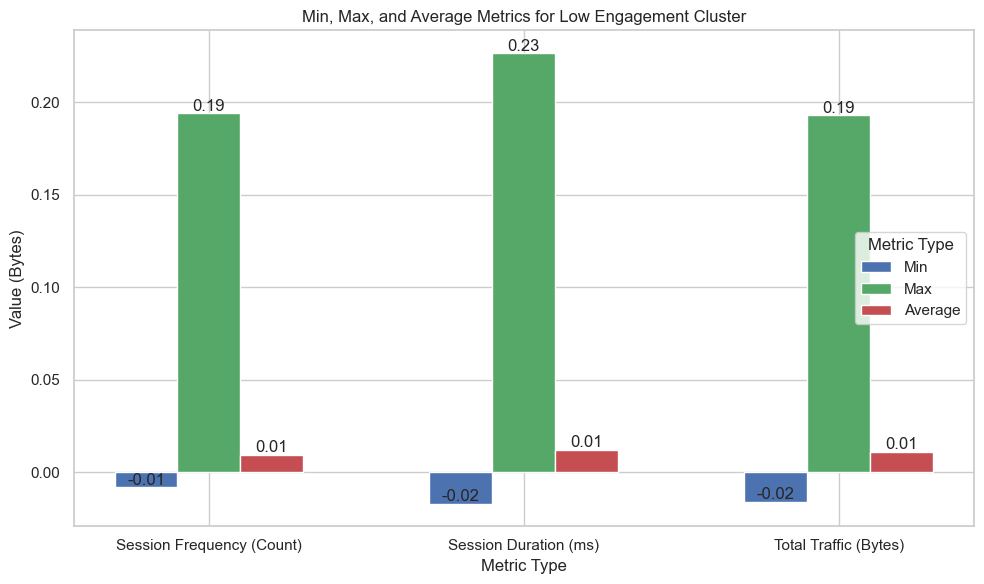

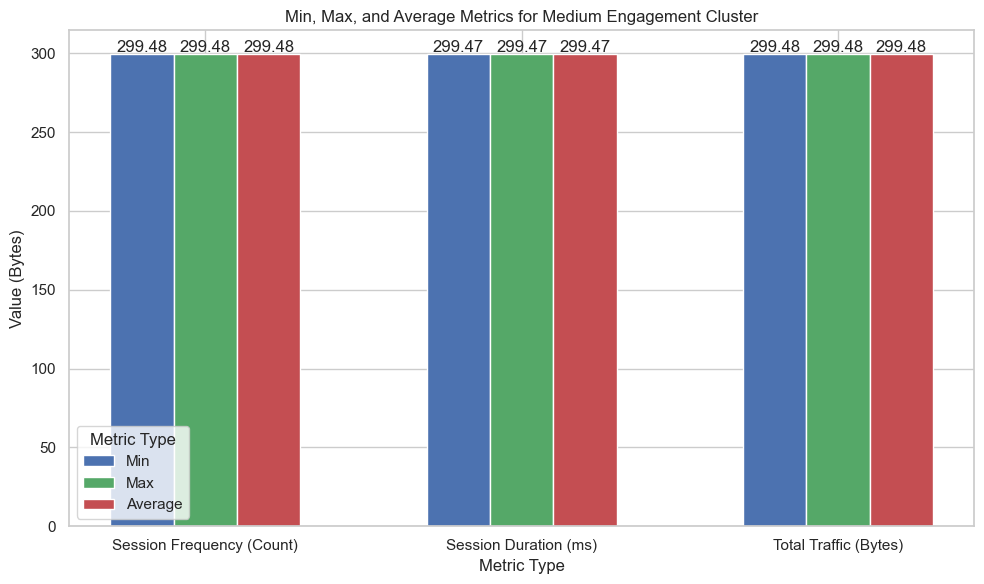

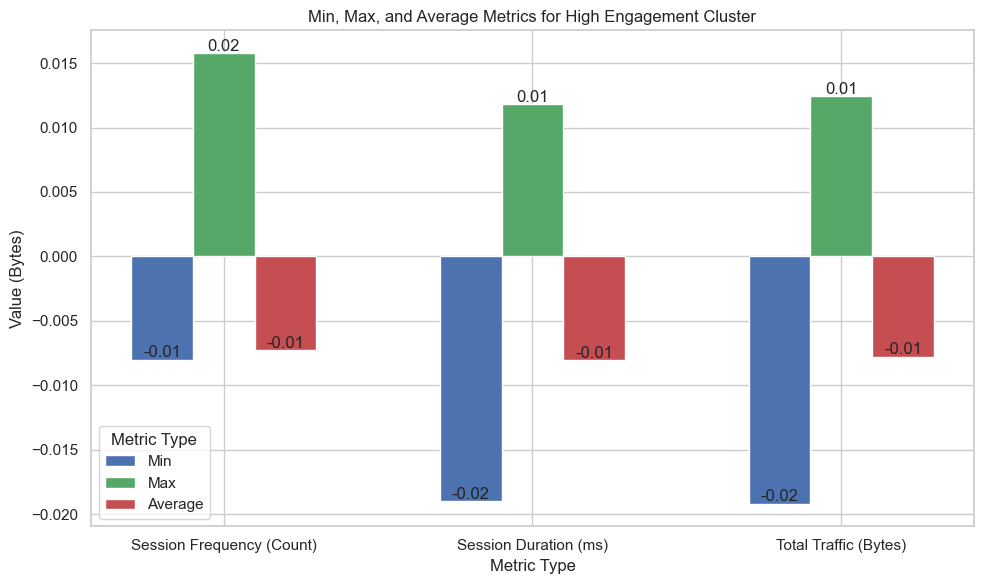

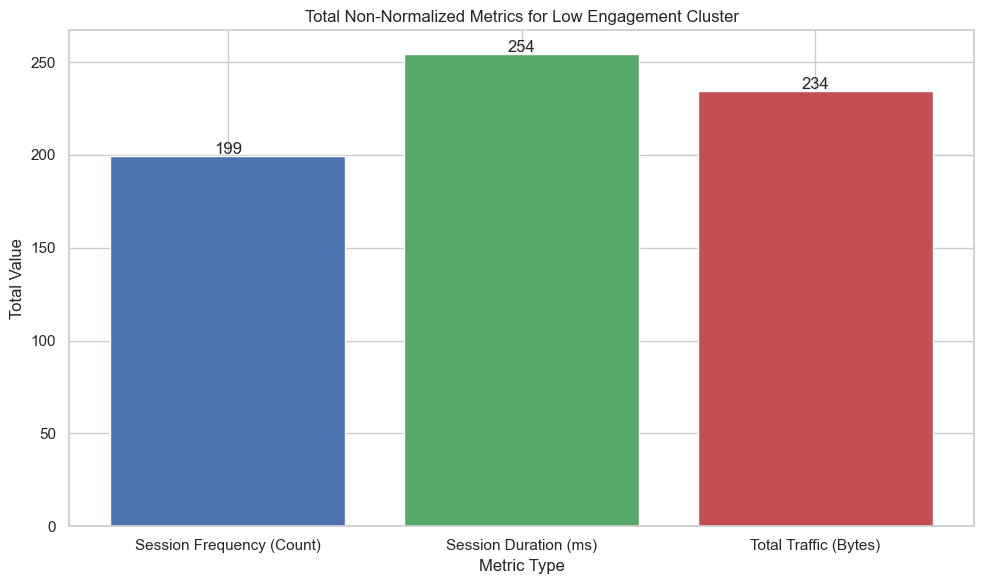

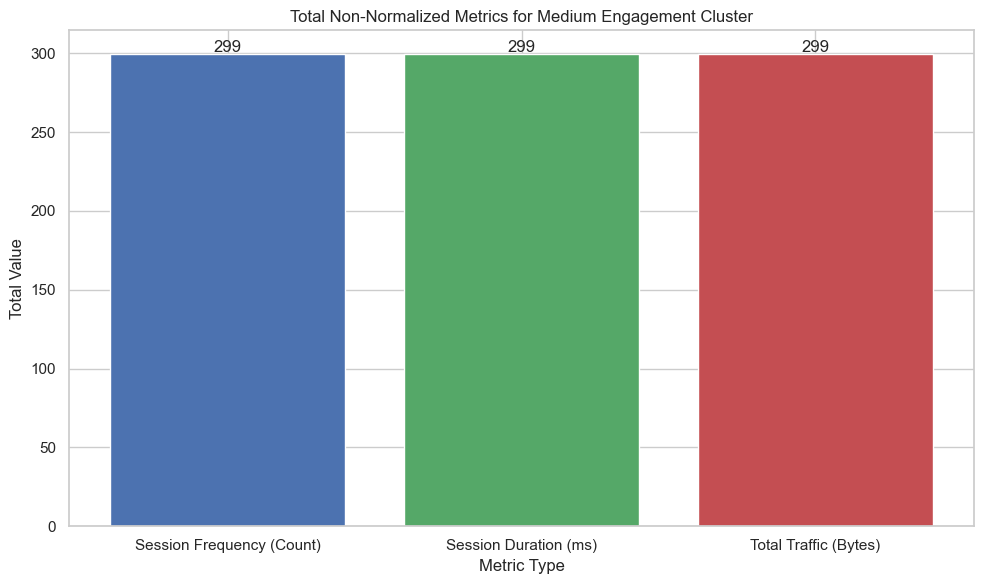

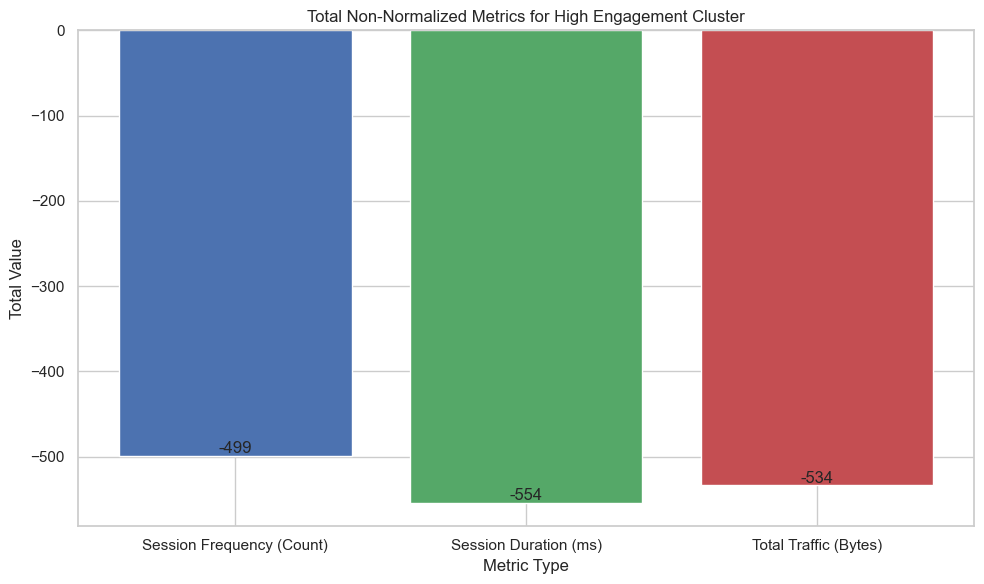

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Assuming df_cleaned is already defined and cleaned

# 1. Aggregate the engagement metrics per customer
session_frequency = df_cleaned.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')
session_duration = df_cleaned.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration')
total_traffic = df_cleaned.groupby('MSISDN/Number').agg(
    total_traffic_ul=('Total UL (Bytes)', 'sum'),
    total_traffic_dl=('Total DL (Bytes)', 'sum')
).reset_index()
total_traffic['Total Traffic (Bytes)'] = total_traffic['total_traffic_ul'] + total_traffic['total_traffic_dl']
total_traffic.drop(columns=['total_traffic_ul', 'total_traffic_dl'], inplace=True)

# Merge the metrics into one DataFrame
engagement_metrics = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics = pd.merge(engagement_metrics, total_traffic[['MSISDN/Number', 'Total Traffic (Bytes)']], on='MSISDN/Number')

# 2. Normalize each engagement metric using StandardScaler
scaler = StandardScaler()
engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']] = scaler.fit_transform(
    engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']]
)

# 3. Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Engagement Cluster'] = kmeans.fit_predict(engagement_metrics[['Session Frequency', 'Session Duration', 'Total Traffic (Bytes)']])

# 4. Label the clusters for better readability
cluster_labels = {0: 'Low Engagement', 1: 'Medium Engagement', 2: 'High Engagement'}
engagement_metrics['Engagement Cluster Label'] = engagement_metrics['Engagement Cluster'].map(cluster_labels)

# 5. Compute Min, Max, Avg, and Total metrics for each cluster
def compute_cluster_metrics(df):
    metrics = df.groupby('Engagement Cluster Label').agg(
        min_session_frequency=('Session Frequency', 'min'),
        max_session_frequency=('Session Frequency', 'max'),
        avg_session_frequency=('Session Frequency', 'mean'),
        total_session_frequency=('Session Frequency', 'sum'),
        min_session_duration=('Session Duration', 'min'),
        max_session_duration=('Session Duration', 'max'),
        avg_session_duration=('Session Duration', 'mean'),
        total_session_duration=('Session Duration', 'sum'),
        min_total_traffic=('Total Traffic (Bytes)', 'min'),
        max_total_traffic=('Total Traffic (Bytes)', 'max'),
        avg_total_traffic=('Total Traffic (Bytes)', 'mean'),
        total_total_traffic=('Total Traffic (Bytes)', 'sum')
    ).reset_index()
    return metrics

cluster_metrics = compute_cluster_metrics(engagement_metrics)

print(cluster_metrics)

# 6. Visualize min, max, and average for each cluster separately, including units in y-axis labels
def plot_min_max_avg_per_cluster(metrics, cluster_label):
    plt.figure(figsize=(10, 6))
    cluster_data = metrics[metrics['Engagement Cluster Label'] == cluster_label]
    metric_names = ['session_frequency', 'session_duration', 'total_traffic']
    
    values = [
        [cluster_data[f'min_{metric}'].values[0] for metric in metric_names],
        [cluster_data[f'max_{metric}'].values[0] for metric in metric_names],
        [cluster_data[f'avg_{metric}'].values[0] for metric in metric_names]
    ]
    
    labels = ['Min', 'Max', 'Average']
    colors = ['#4c72b0', '#55a868', '#c44e52']
    
    x = np.arange(len(metric_names))
    width = 0.2
    
    for i, (vals, label, color) in enumerate(zip(values, labels, colors)):
        plt.bar(x + i * width, vals, width, label=label, color=color)
    
    plt.title(f'Min, Max, and Average Metrics for {cluster_label} Cluster')
    plt.xlabel('Metric Type')
    
    # Set y-axis label with units
    if cluster_label == 'Session Frequency':
        plt.ylabel('Value (Count)')
    elif cluster_label == 'Session Duration':
        plt.ylabel('Value (ms)')
    else:
        plt.ylabel('Value (Bytes)')
        
    plt.xticks(x + width, ['Session Frequency (Count)', 'Session Duration (ms)', 'Total Traffic (Bytes)'])
    plt.legend(title='Metric Type')
    plt.tight_layout()
    
    # Add data labels
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    plt.show()

# Plot for each cluster
for cluster in ['Low Engagement', 'Medium Engagement', 'High Engagement']:
    plot_min_max_avg_per_cluster(cluster_metrics, cluster)

# 7. Additional plots for total non-normalized metrics per cluster, including units in y-axis labels
def plot_total_non_normalized(metrics, cluster_label):
    plt.figure(figsize=(10, 6))
    cluster_data = metrics[metrics['Engagement Cluster Label'] == cluster_label]
    
    metric_names = ['session_frequency', 'session_duration', 'total_traffic']
    values = [cluster_data[f'total_{metric}'].values[0] for metric in metric_names]
    
    colors = ['#4c72b0', '#55a868', '#c44e52']
    
    plt.bar(metric_names, values, color=colors)
    
    plt.title(f'Total Non-Normalized Metrics for {cluster_label} Cluster')
    plt.xlabel('Metric Type')
    
    # Set y-axis label with units
    plt.ylabel('Total Value')
    
    plt.xticks([0, 1, 2], ['Session Frequency (Count)', 'Session Duration (ms)', 'Total Traffic (Bytes)'])
    plt.tight_layout()
    
    # Add data labels
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    plt.show()

# Plot total non-normalized metrics for each cluster
for cluster in ['Low Engagement', 'Medium Engagement', 'High Engagement']:
    plot_total_non_normalized(cluster_metrics, cluster)


### Phase 4: Application-Level engagement

In this phase we are going to show the aggreagate user total traffic per application and identify the top 10 most engaged users per app. Additionally we are also going to show the top 3 applications.

In [15]:
print(df_cleaned.columns.tolist())

['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (


Top 10 Most Engaged Users for Social Media (in GB):
+-------+-------------+-----------------------------------+
|       |     User ID |   Social Media Total Traffic (GB) |
+=======+=============+===================================+
| 53042 | 3.36637e+10 |                        43.0023    |
+-------+-------------+-----------------------------------+
| 12924 | 3.36263e+10 |                         0.0403959 |
+-------+-------------+-----------------------------------+
| 36450 | 3.36597e+10 |                         0.0329803 |
+-------+-------------+-----------------------------------+
|  5835 | 3.36149e+10 |                         0.0263513 |
+-------+-------------+-----------------------------------+
| 12578 | 3.36258e+10 |                         0.0252719 |
+-------+-------------+-----------------------------------+
| 64516 | 3.36672e+10 |                         0.0225826 |
+-------+-------------+-----------------------------------+
| 70358 | 3.36691e+10 |                        

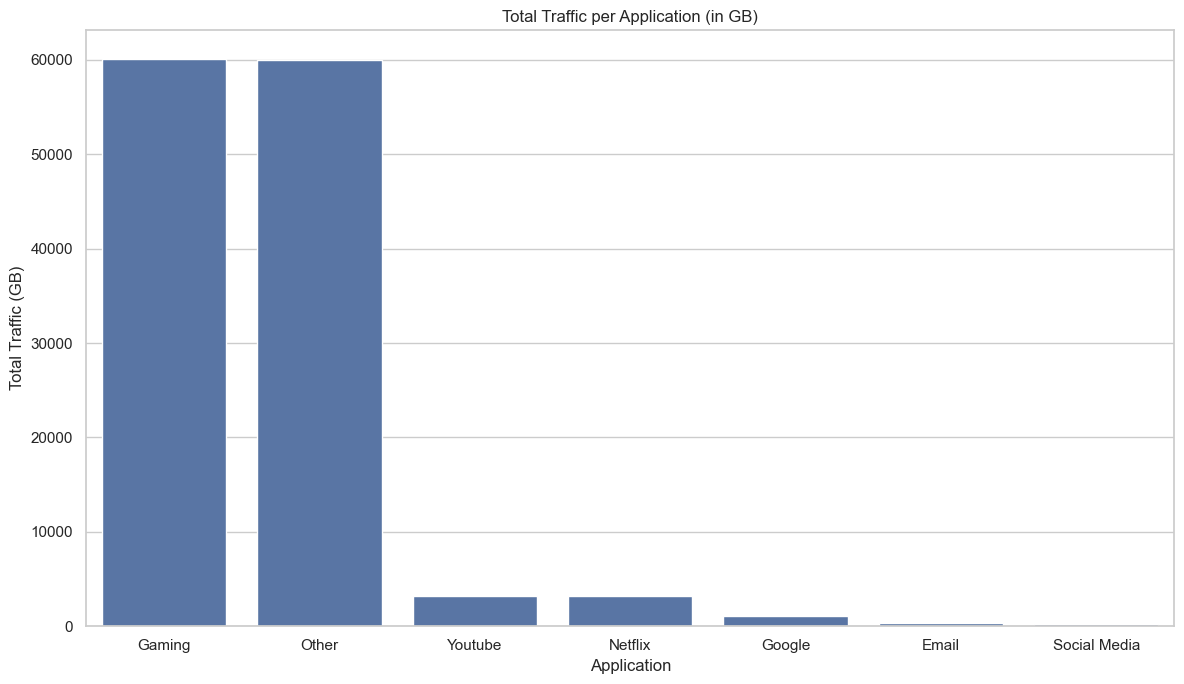

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# Step 1: Aggregate User Total Traffic per Application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
df_cleaned['Total Traffic (GB)'] = (df_cleaned['Total DL (Bytes)'] + df_cleaned['Total UL (Bytes)']) / (1024 ** 3)

# Create a dictionary to store top 10 users per application and total traffic for each app
top_10_users_per_app = {}
total_traffic_per_app = {}

for app in applications:
    # Calculate total traffic (download + upload) for each application and convert to GB
    df_cleaned[f'{app} Total Traffic (GB)'] = (df_cleaned[f'{app} DL (Bytes)'] + df_cleaned[f'{app} UL (Bytes)']) / (1024 ** 3)
    
    # Aggregate total traffic per user (MSISDN/Number) for each application
    top_users = df_cleaned.groupby('MSISDN/Number')[f'{app} Total Traffic (GB)'].sum().reset_index()
    
    # Get the top 10 most engaged users per application
    top_10_users = top_users.sort_values(by=f'{app} Total Traffic (GB)', ascending=False).head(10)
    top_10_users_per_app[app] = top_10_users
    
    # Store total traffic for the application
    total_traffic_per_app[app] = df_cleaned[f'{app} Total Traffic (GB)'].sum()

# Part 1: Display the top 10 most engaged users per application as a table
for app, top_10_users in top_10_users_per_app.items():
    print(f"\nTop 10 Most Engaged Users for {app} (in GB):")
    print(tabulate(top_10_users, headers=["User ID", f"{app} Total Traffic (GB)"], tablefmt="grid"))

# Part 2: Visualize the total traffic of all applications, including the breakdown of the "Other" category
other_sub_apps = ['Other DL (Bytes)', 'Other UL (Bytes)']
other_traffic = df_cleaned[other_sub_apps].sum().sum() / (1024 ** 3)  # Convert to GB
total_traffic_per_app['Other'] = other_traffic

# Convert total_traffic_per_app to a DataFrame
traffic_df = pd.DataFrame(list(total_traffic_per_app.items()), columns=['Application', 'Total Traffic (GB)'])

# Sort the applications by total traffic
sorted_traffic_df = traffic_df.sort_values(by='Total Traffic (GB)', ascending=False)

# Plot all applications, including the breakdown of the "Other" category
plt.figure(figsize=(12, 7))
sns.barplot(x='Application', y='Total Traffic (GB)', data=sorted_traffic_df)
plt.title('Total Traffic per Application (in GB)')
plt.xlabel('Application')
plt.ylabel('Total Traffic (GB)')
plt.tight_layout()
plt.show()


### 5. Clustering refinement

In this phase we are going to use the elbow method to edetermine the optimal level of k for clustering. After indicating the optimal level of clustering we are going to interpret the results at last and complete the user engagement analysis.

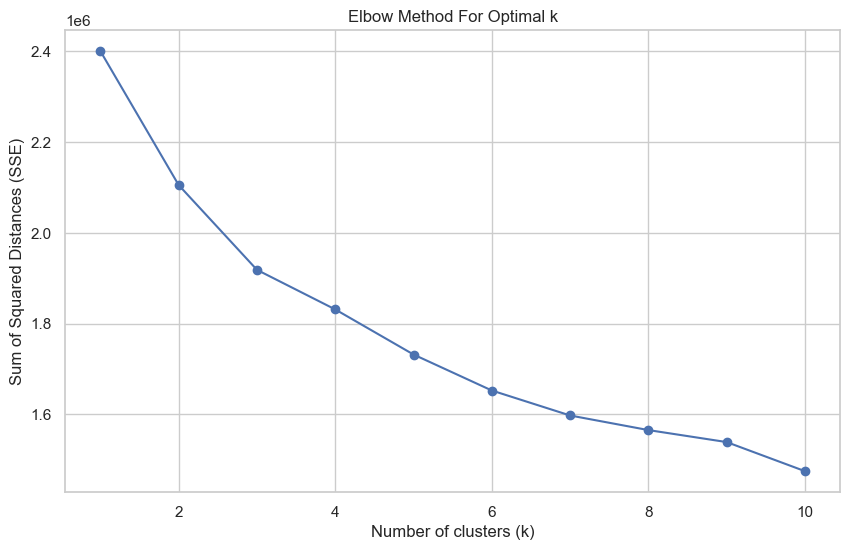

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select relevant columns for engagement metrics
engagement_metrics = [
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 
    'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 
    'TCP UL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Youtube DL (Bytes)', 
    'Youtube UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 
    'Total UL (Bytes)', 'Total DL (Bytes)'
]

# Preprocess the data
X = df_cleaned[engagement_metrics].fillna(0)  # Replace NaN values with 0 if any
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to determine optimal k
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the elbow graph, let's assume the optimal k is 4
optimal_k = 4  # You should select this based on your elbow graph observation

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(X_scaled)

### Interpretation

The elbow method suggests that the optimal value of k is at 4. At this point, the SSE (Sum of Squared Errors) begins to plateau, indicating diminishing returns for increasing k. 

By applying K-means clustering, users are grouped into 4 distinct engagement clusters. These clusters highlight different levels of user engagement based on various metrics such as throughput, retransmission volumes, and specific app usage (e.g., social media, gaming). 

This clustering is very helpful in identifying user behavior patterns, enabling targeted service enhancements to improve user experience.
